In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Whole data, which is avaiable for me is train - I'll devide it into train and validate; test is for prediction for kaggle submission

In [2]:
data = pd.read_csv('./train.csv', index_col='PassengerId')
data.shape

(891, 11)

In [3]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Because there are a lot of nan in Cabin column, Name just does not affect your chance of survival; And I want to Label encode ticket values

In [5]:
data = data.loc[:, data.columns != ('Cabin' or 'Name' or 'Ticket')]

In [6]:
data.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [7]:
num_cols = [
    'Pclass',
    'Age',
    'SibSp',
    'Parch',
    'Fare',

]

cat_cols = [
    'Sex',
    'Embarked',
]

target_col = 'Survived'

X = data[num_cols + cat_cols]
y = data[[target_col]].values.ravel()

I need to check numerical features:

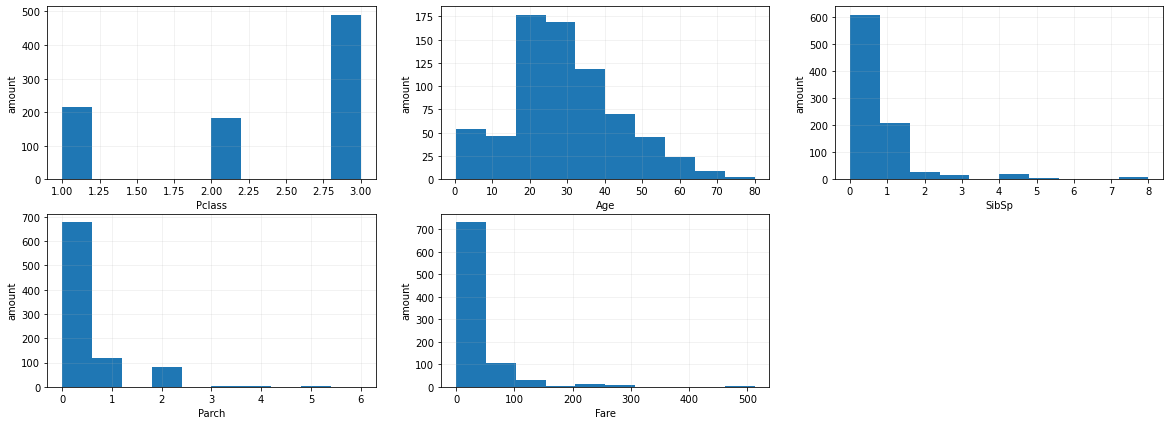

In [8]:
plt.figure(figsize=(20, 7))

sp = None
for num_col in num_cols:
    sp = plt.subplot(2, 3, num_cols.index(num_col) + 1)

    plt.hist(X[num_col])

    plt.ylabel("amount")
    plt.xlabel(num_col)
    plt.grid(alpha=0.2)

plt.show()

Let's check categorical features and check 2 nan in Emarked to the most common ones

In [9]:
X.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
X.loc[X.Embarked.isna(), 'Embarked'] = 'S'

/home/alphonse/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


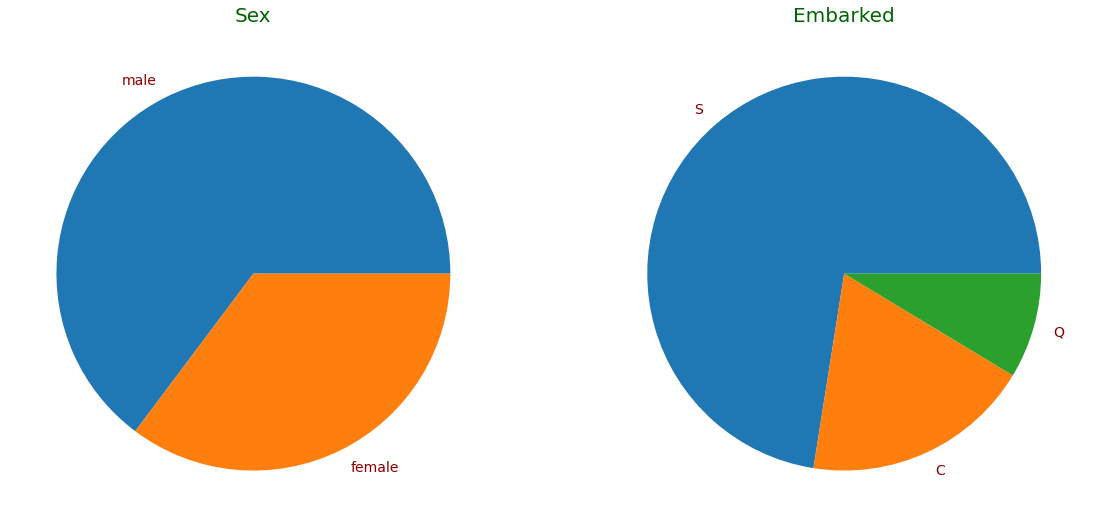

In [11]:
sp = None
plt.figure(figsize=(30, 20))
for cat_col in cat_cols:
    sp = plt.subplot(1, 3, cat_cols.index(cat_col) + 1)
    my_labels = X[cat_col].unique()
    my_values = X[cat_col].value_counts()
    plt.title(cat_col, fontdict={'fontsize': 20, 'color': 'darkgreen'})
    plt.pie(my_values, labels=my_labels, textprops={'color' : 'darkred', 'fontsize' : 14})
plt.show()
None

First I will try a linear model:

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

In [13]:
from sklearn.metrics import roc_auc_score

Label encoder is only for target column!!!, it was not designed for encoding of categorical features

In [14]:
numerical_transformer = Pipeline(
        steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]
)

# Если хотим к одному месту применить последовательно несколько препроцессоров, то их надо закидывать в пайплайн

col_transformer = make_column_transformer(
        (numerical_transformer, num_cols),
        (OneHotEncoder(), cat_cols[:2]),
        # (OrdinalEncoder(), ['Ticket'])
)

In [15]:
clf = LogisticRegression(max_iter=1000, tol=0.001, solver='saga')

pipe = Pipeline(
    steps=[("preprocessor", col_transformer), ("classifier", clf)]
)

# if you want to specify step of Pipeline for GridSearchCV you just put it's name from pipeline, then __ and the parameter name
param_grid = {
    'classifier__C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': [None, 'balanced']
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=3, scoring='accuracy')

In [16]:
search.fit(X, y)
None

In [17]:
estimator = search.best_estimator_      # every transformer is already into estimator

search.best_score_

0.7923681257014591

Let's make submission for linear model:

In [18]:
X_test = pd.read_csv('./test.csv')[num_cols + cat_cols]

In [19]:
X_test.isna().sum()

Pclass       0
Age         86
SibSp        0
Parch        0
Fare         1
Sex          0
Embarked     0
dtype: int64

In [20]:
# It seems like after fitting search, it has already fitted whole X and y, but I would better do it one more time for safety:

estimator.fit(X, y)
None

In [21]:
y_pred = estimator.predict(X_test)

In [22]:
submission_df = pd.read_csv('./gender_submission.csv', index_col='PassengerId')

In [23]:
submission_df['Survived'] = y_pred

In [24]:
submission_df.to_csv('./my_linear_submission.csv')